## Calibration of Sumo model in python

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from dynamita.sumo import *
import time
import pandas as pd  

In [3]:
#Provide the installation path and the license file
sumo = Sumo(sumoPath="C:/Users/zeru/AppData/Local/Dynamita/Sumo16", licenseFile=r"networklicense.sumolic")

License OK...


In [48]:
# Define data communication interval
def datacomm_callback(sumo):
    t.append(sumo.core.csumo_var_get_time_double(sumo.handle))
    #snhx.append(sumo.core.csumo_var_get_pvtarray_pos(sumo.handle, snhx_pos, 0))
    for i in range(6):
        snhx[i].append(sumo.core.csumo_var_get_pvtarray_pos(sumo.handle, snhx_pos, i))
        sno2[i].append(sumo.core.csumo_var_get_pvtarray_pos(sumo.handle, sno2_pos, i))
        sno3[i].append(sumo.core.csumo_var_get_pvtarray_pos(sumo.handle, sno3_pos, i))
        
    return 0

In [49]:
# Define function to load the model
def loadModel():
    sumo.unload_model()
    if not sumo.load_model('GSBR011518.sumo'):
        print ('Model successfuly loaded!')
        sumo.register_datacomm_callback(datacomm_callback)
        sumo.core.csumo_command_send(sumo.handle, b'execute script_Initialize.scs;')

In [57]:
def getVars():
    snhx_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__GranularSBR__SNHx')
    sno2_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__GranularSBR__SNO2')
    sno3_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__GranularSBR__SNO3')
    
    return (snhx_pos,sno2_pos,sno3_pos)

In [77]:
loadModel()
snhx_pos,sno2_pos,sno3_pos=getVars()
print(snhx_pos)
print(sno2_pos)
print(sno3_pos)

Model successfuly loaded!
86
87
88


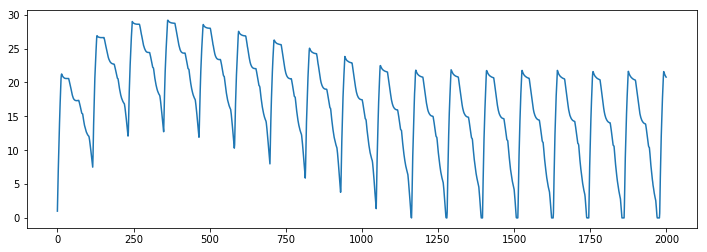

In [15]:
import_data= eval(open('snhx_file.txt', 'r').read())
plt.figure(figsize=(12,4))
plt.plot(import_data[:2000])
plt.show()

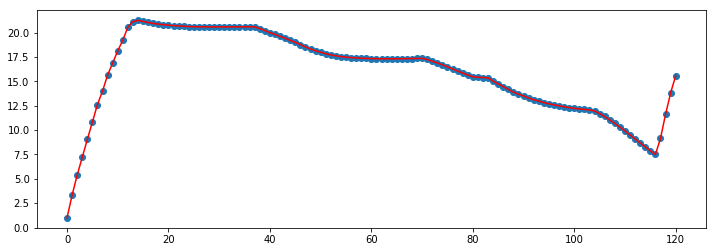

In [338]:
cal_data = np.array(import_data[:121])#(np.random.normal(-1,1,121))
plt.figure(figsize=(12,4))
plt.scatter(np.arange(121),cal_data)
plt.plot(import_data[:121],'r')
plt.show()

In [340]:
type(cal_data)

numpy.ndarray

In [378]:
param_names=['KO2_AOB_AS', 'muAOB']
lower=np.array([0.1,0.2])
upper=np.array([3,2])
all_rss=[]


In [384]:
def model(params):
    stop_t=6*3600*1000
    dataComm = 180000
    sumo.set_stopTime(stop_t)
    sumo.set_dataComm(dataComm)
    
    no3={}
    no2={}
    snh={}

    set_cmd='set Sumo__Plant__Sumo2__'
    command=''
    #Convert internals to bounds
    #params=[0.5,1.2]
    param=lower+(np.sin(params)+1)*(upper-lower)/2
    
    #Build the Sumo command
    for j in range(len(param)):
        command +=set_cmd + param_names[j] + ' '+ str(param[j]) + '; \n'

    sumo.core.csumo_command_send(sumo.handle, command.encode('utf8'))
    
    global t, snhx, sno2,sno3
    t = []
    snhx=[[] for i in range(6)]
    sno2=[[] for i in range(6)]
    sno3=[[] for i in range(6)]
    
    sumo.run_model()

    while not sumo.simulation_finished:
            time.sleep(0.01)

    snh=np.array(snhx[0])
    #Check the length of the calibration data and model output are the same
    tl=min(len(t), len(cal_data))
    # Define the optimization function which is the residuals sum squared (RSS)
    rss=np.sqrt(sum((snh[:tl]-cal_data[:tl])**2))
    rss_p=np.concatenate((np.array(param),np.array([rss])),axis=0)
    all_rss.append(rss_p.tolist())
    print("Evaluating the MODEL",rss_p)
    return rss    

### Start the optimization process

In [383]:
all_rss

[array([ 22.01106089,  22.61106089]),
 array([ 21.10063116,  21.7374975 ]),
 array([  1.26      ,   1.64      ,  16.31460873]),
 array([  1.24571144,   1.64      ,  16.26625626])]

In [197]:
x_params=[]
def store_x(xx):
    x_params.append(xx.tolist())  

In [ ]:
#rss_data=np.array(all_rss[44:])
x= np.linspace(0.1,3,6)
y= np.linspace(0.2,2,6)
smpl=[]
rss_out=np.empty((len(x),len(y)))
for i in range(len(x)):
    for j in range(len(y)):
        smpl.append([x[i],y[j]])
        rss_out[i,j]=model([x[i],y[j]])

In [ ]:
rss_out

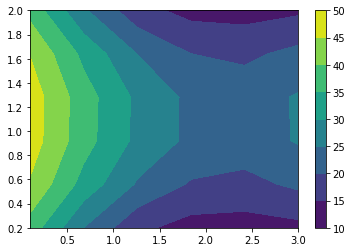

In [478]:
import scipy as sp

X, Y = np.meshgrid(x, y)
fig= plt.figure()

ct=plt.contourf(X, Y, rss_out)

plt.colorbar()
plt.show()


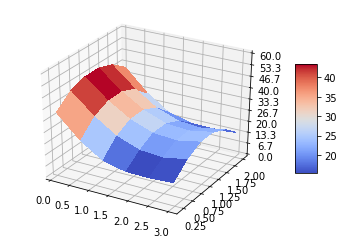

In [483]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig2 = plt.figure()
ax2 = fig2.gca(projection='3d')
surf = ax2.plot_surface(X, Y, rss_out, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax2.set_zlim(0, 60)
ax2.zaxis.set_major_locator(LinearLocator(10))
ax2.zaxis.set_major_formatter(FormatStrFormatter('%.01f'))

# Add a color bar which maps values to colors.
fig2.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [455]:
cond=rss_data[:,:1]==np.array(smpl).round(2)

C:\Users\zeru\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


In [456]:
cond

False

In [ ]:
%%time
# Generate samples
res={}
#par_set=np.random.randint(6, size=(50,2))
x= np.linspace(0.1,3,6)
y= np.linspace(0.2,2,6)

#Scale the random set using the specified ranges
#par_set=lower +(upper-lower)*par_set/5
#res_list = {} #sp.empty(5, dtype = object)
for i in range(len(x)):
    for j in range(len(y)):
        # Specify initial estimates of the parameters
        p0=np.array([x[i],y[j]])
        #p0 = par_set[i,:]
        #convert them to unbounded values 
        x0=np.arcsin(2*(p0-lower)/(upper-lower)-1)
        #print(x0)
        # We will be using Nelder-Mead simplex optimization

        res[i] = minimize(model, x0, method='nelder-mead',callback=store_x, 
                         options={'maxiter':20,'fatol':0.05,'xtol': 1e-3, 'disp': True})

In [388]:
res_x=res[2].x
convert=lambda x:(lower+(np.sin(x)+1)*(upper-lower)/2)
res_x=convert(res_x)
res_x

array([ 0.32093587,  1.0253318 ])

In [393]:
all_data=np.array(all_rss[4:])
all_data.shape

(43, 3)

In [261]:
x_array=np.array(x_params)
x_array.shape

(87, 2)

In [262]:
#Convert back to the actual bounds
x_convert=convert(x_array)

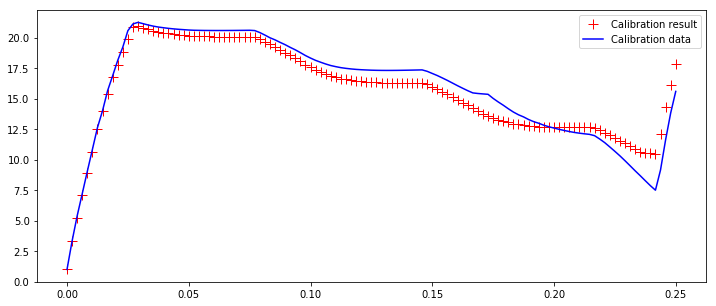

In [263]:
plt.figure(figsize=(12,5))
plt.plot(t,snhx[0],'r+', ms=10, label="Calibration result")
plt.plot(t,cal_data,'b', label="Calibration data")
plt.legend(loc="best")
plt.show()

In [ ]:
plt.figure()
#plt.scatter(x_convert[:,0],x_convert[:,1])
#plt.plot(res_x[0],res_x[1],'r+', ms=30)
plt.plot(x_convert[:,0])
plt.plot(x_convert[:,1])
plt.show()

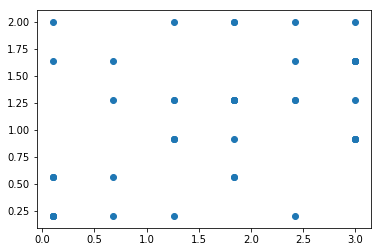

In [411]:
par_set=np.random.randint(6, size=(50,2))
#delta=[0.1,0.3]
par_set=lower +(upper-lower)*par_set/5
plt.figure()
plt.scatter(par_set[:,0],par_set[:,1])
plt.show()